In [22]:
import json
import os
import warnings
from datetime import datetime
from shutil import copyfile

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pandas_profiling as pp
import lightgbm as lgb
import optuna.integration.lightgbm as lgbopt
import seaborn as sns
import shap
from catboost import CatBoostClassifier, Pool, cv
from category_encoders import TargetEncoder, WOEEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import (
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from tqdm import tqdm

np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})  # `easy numbers` mode
pd.set_option("display.max_columns", None)                                # `show whole df` mode
warnings.filterwarnings("ignore")                                         # `do not disturbe` mode
optuna.logging.set_verbosity(optuna.logging.FATAL)

sns.set_context("paper", font_scale=1.4)

# cross-validation settings
N_SPLITS = 5
N_REPEATS = 5
SEED = 42

## LightGBM

In [31]:
X_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "X_train.csv"))
X_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data", "X_test.csv"))
y_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "y_train.csv"))
y_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "y_test.csv"))

In [34]:
dtrain = lgb.Dataset(X_train, label=y_train, params={'verbosity': -1})

In [ ]:
params = {
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
tuner = lgbopt.LightGBMTunerCV(
    params, dtrain, verbose_eval=-1, early_stopping_rounds=100, folds=cv
)

tuner.run()



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: -inf:   0%|                                                         | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: 0.778770:   0%|                                                     | 0/7 [00:02<?, ?it/s]

feature_fraction, val_score: 0.778770:  14%|######4                                      | 1/7 [00:02<00:12,  2.04s/it]

feature_fraction, val_score: 0.778770:  14%|######4                                      | 1/7 [00:02<00:12,  2.04s/it]

feature_fraction, val_score: 0.779756:  14%|######4                                      | 1/7 [00:04<00:12,  2.04s/it]

feature_fraction, val_score: 0.779756:  29%|############8                                | 2/7 [00:04<00:10,  2.12s/it]

feature_fraction, val_score: 0.779756:  29%|############8                                | 2/7 [00:04<00:10,  2.12s/it]

In [65]:
model = lgb.LGBMClassifier(**tuner.best_params)

# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
scores = cross_validate(model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True)
mean_train_auc = scores["train_score"].mean()
mean_test_auc = scores["test_score"].mean()
std_test_auc = scores["test_score"].std()

# Test
model.fit(X = X_train, y = np.ravel(y_train))
preds = model.predict_proba(X_test)[::,1]
test_auc = metrics.roc_auc_score(y_test, preds)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.283241488976802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.283241488976802
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.3804659222033817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3804659222033817
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.283241488976802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.283241488976802
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Wa

In [66]:
# Print the results
print(f"mean_train_GINI:\t {np.round(mean_train_auc * 2 - 1, 4)}")
print("mean_dev_GINI:\t\t", np.round(mean_test_auc * 2 - 1, 4), f"({np.round(std_test_auc, 4)})")
print(f"test_GINI:\t\t {np.round(test_auc * 2 - 1, 4)}")

mean_train_GINI:	 0.7154
mean_dev_GINI:		 0.5607 (0.0058)
test_GINI:		 0.5623


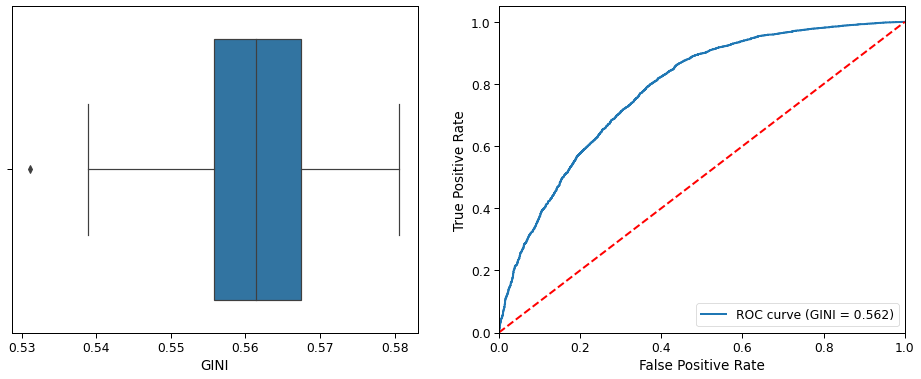

In [67]:
# boxplot
fig, axs = plt.subplots(1, 2, figsize=(16,6))
fig1 = sns.boxplot(scores["test_score"]*2-1, ax=axs[0])
fig1.set_xlabel('GINI')

# RoC
preds = model.predict_proba(X_test)[::,1]
test_auc = metrics.roc_auc_score(y_test, preds)

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
lw=2
axs[1].plot(fpr, tpr, lw=lw, label='ROC curve (GINI = %0.3f)' % (test_auc * 2 - 1))
axs[1].plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].legend(loc="lower right")

plt.savefig('Img\lr_cv_roc.png', facecolor='w')

### Performance vs sample size

In [57]:
n_sample = [50, 100, 500, 1000, 2000, 3000, 5000, 7000, 10000, 20000]
gini_sample = []

for sample_size in n_sample:
    X_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "X_train.csv"))
    X_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "X_test.csv"))
    y_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "y_train.csv"))
    y_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "y_test.csv"))

    X_train = X_train.sample(sample_size, random_state=SEED).copy()
    y_train = y_train.sample(sample_size, random_state=SEED).copy()

    
    # Hyperparameters optimization
    dtrain = lgb.Dataset(X_train, label=y_train)
    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    tuner = lgbopt.LightGBMTunerCV(
        params, dtrain, verbose_eval=-1, early_stopping_rounds=100, folds=cv, verbosity=False, show_progress_bar=False
    )
    tuner.run()
    
    
    model = lgb.LGBMClassifier(**tuner.best_params)
    
    # Cross-validation
    cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
    scores = cross_validate(model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True)
    mean_train_auc = scores["train_score"].mean()
    mean_test_auc = scores["test_score"].mean()
    std_test_auc = scores["test_score"].std()

    # Test
    model.fit(X = X_train, y = np.ravel(y_train))
    preds = model.predict_proba(X_test)[::,1]
    test_auc = metrics.roc_auc_score(y_test, preds)

    # Print the results
    print(f"Sample size: {sample_size}")
    print(f"mean_train_GINI:\t {np.round(mean_train_auc * 2 - 1, 4)}")
    print("mean_dev_GINI:\t\t", np.round(mean_test_auc * 2 - 1, 4), f"({np.round(std_test_auc, 4)})")
    print(f"test_GINI:\t\t {np.round(test_auc * 2 - 1, 4)}\n")
    
    gini_sample.append(test_auc)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.003693161239332666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003693161239332666
[LightGBM] [Warning] bagging_fraction is set=0.9027000203882406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9027000203882406
[LightGBM] [Warning] lambda_l2 is set=0.0438410719495033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0438410719495033
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.003693161239332666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003693161239332666
[LightGBM] [Warning] bagging_fraction is set=0.9027000203882406, subsample=1.0 will be ig

num_leaves, val_score: 0.780920:   5%|##3                                            | 1/20 [11:13<3:33:10, 673.16s/it]


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.0009952407922071476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009952407922071476
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=8.816441351632395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.816441351632395
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0.0009952407922071476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009952407922071476
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


In [58]:
n_sample = pd.Series(n_sample, name='Training sample size')
gini_sample = pd.Series(gini_sample, name='GINI')*2-1
res =  pd.concat([n_sample, gini_sample], axis=1)

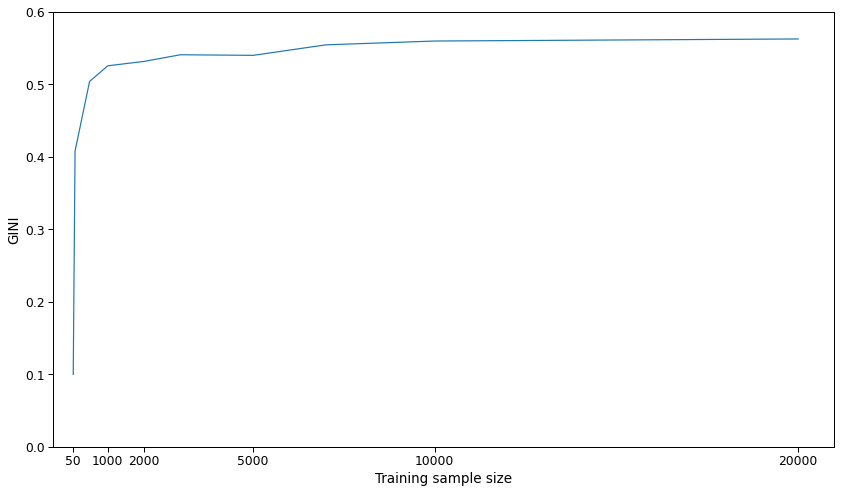

In [62]:
fig, ax = plt.subplots(figsize=(14,8))
sns.lineplot(data=res, x='Training sample size', y='GINI')
ax.set_ylim([0, 0.6])
ax.set_xlim([-500, None])
ax.set_xticks([50, 1000, 2000, 5000, 10000, 20000])

In [73]:
import joblib

lgbm = {
    'val_scores': scores["test_score"]*2-1,
    'fpr': fpr,
    'tpr': tpr,
    'test_auc': test_auc,
    'n_sample': list(n_sample),
    'gini_sample': list(gini_sample)
}

joblib.dump(lgbm, os.path.join('Experiment results', 'lgbm_res.pth'))

['Experiment results\\lgbm_res.pth']